In [1]:

%load_ext autoreload
%autoreload 2
%matplotlib inline
%cd ../..

/media/samuele/Disco/PycharmProjectsUbuntu/MARL-CER


In [2]:
import matplotlib.pyplot as plt
from functools import partial
from jax_tqdm import scan_tqdm

import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly
import seaborn as sns

from plotly_resampler import register_plotly_resampler, FigureWidgetResampler
# register_plotly_resampler(mode="auto", default_n_shown_samples=4500)

import pandas as pd

from algorithms.utils import restore_state, restore_state_multi_agent

import numpy as np

import jax
import jax.numpy as jnp
# jax.config.update("jax_enable_x64", True)


2025-03-27 12:37:29.872421: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743075449.891588    6286 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743075449.896973    6286 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
from ernestogym.envs_jax.multi_agent.env import RECEnv
# from ernestogym.envs_jax.single_agent.env_trading_soc import MicroGridEnvSocAction

In [4]:
def my_env_creator(params, battery_type, env_type='normal'):
    if env_type == 'normal':
        env = RECEnv(params, battery_type)
    return env

In [5]:
def print_heatmap(X, Y, Z, num_bins=10, x_label='', y_label='', title='', n_decimals_axes=0):
    z_grid, y_edges, x_edges = np.histogram2d(Y, X, bins=(num_bins, num_bins), weights=Z)
    counts, _, _ = np.histogram2d(Y, X, bins=(num_bins, num_bins))

    z_grid = np.divide(z_grid, counts, out=np.full_like(z_grid, fill_value=np.nan), where=counts > 0)

    x_centers = (x_edges[1:]+x_edges[:-1])/2
    y_centers = (y_edges[1:]+y_edges[:-1])/2

    x_ticks = [f'{v:.{n_decimals_axes}f}' for v in x_centers]
    y_ticks = [f'{v:.{n_decimals_axes}f}' for v in y_centers]

    plt.figure(figsize=(8, 6))
    sns.heatmap(z_grid, xticklabels=x_ticks, yticklabels=y_ticks, cmap='coolwarm', center=0).invert_yaxis()

    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.show()

def plot_hist_soc(soc, actions):
    hist, bins = np.histogram(soc, weights=actions, bins=16)
    counts, _ = np.histogram(soc, bins=16)

    hist = np.divide(hist, counts, where=counts > 0)

    bins_ctrs = (bins[:-1] + bins[1:])/2

    plt.bar(bins_ctrs, hist, width=0.045)

    plt.xlabel('SoC')
    plt.ylabel('Mean action')

In [6]:
from ernestogym.envs_jax.multi_agent.utils import parameter_generator

In [7]:
# pack_options = "ernestogym/ernesto_jax/data/battery_new/pack.yaml"
# pack_options = "ernestogym/ernesto_jax/data/battery_new/pack_cheap.yaml"
# pack_options = "ernestogym/ernesto_jax/data/battery_new/pack_init_full.yaml"
# pack_options = "ernestogym/ernesto_jax/data/battery_new/pack_init_full_cheap.yaml"
pack_options = "ernestogym/ernesto_jax/data/battery_new/pack_init_half_full_cheap.yaml"

ecm = "ernestogym/ernesto_jax/data/battery_new/models/electrical/thevenin_pack.yaml"
# ecm = "ernestogym/ernesto_jax/data/battery_new/models/electrical/thevenin_fading_pack.yaml"
r2c = "ernestogym/ernesto_jax/data/battery_new/models/thermal/r2c_thermal_pack.yaml"
# bolun = "ernestogym/ernesto_jax/data/battery_new/models/aging/bolun_pack.yaml"
bolun = "ernestogym/ernesto_jax/data/battery_new/models/aging/bolun_pack.yaml"


# world = "ernestogym/envs_jax/multi_agent/world_deg_test.yaml"
# world = "ernestogym/envs_jax/multi_agent/world_deg_test_exp_avg.yaml"
# world = "ernestogym/envs_jax/multi_agent/world_deg_test_split_demands.yaml"
# world = "ernestogym/envs_jax/single_agent/world_fading.yaml"
# world = "ernestogym/envs_jax/multi_agent/world_deg_test_split_generations_only_trad_exp_avg.yaml"
# world = "ernestogym/envs_jax/multi_agent/world_deg_test_split_generations_exp_avg.yaml"
# world = "ernestogym/envs_jax/multi_agent/world_deg_test_split_generations_exp_avg_passive.yaml"
# world = "ernestogym/envs_jax/multi_agent/world_deg_test_split_generations_exp_avg_new_clip.yaml"
# world = "ernestogym/envs_jax/multi_agent/world_deg_test_split_demands_exp_avg.yaml"
# world = "ernestogym/envs_jax/multi_agent/world_deg_test_all_the_same_debug_like_single.yaml"

world = 'ernestogym/envs_jax/multi_agent/world_deg_test_split_generations_passive_no_gen.yaml'
# world = 'ernestogym/envs_jax/multi_agent/world_deg_test_split_generations_passive_scaled_no_gen.yaml'


# battery_type = 'fading'
# battery_type = 'degrading'
battery_type = 'degrading_dropflow'

params = parameter_generator(
    input_var='current',
    battery_options=pack_options,
    electrical_model=ecm,
    thermal_model=r2c,
    aging_model=bolun,
    world_options=world,
    # use_reward_normalization=True

)

# num_iter = 8760 * 28

params

yaaaas2


{'num_battery_agents': 4,
 'num_passive_houses': 1,
 'batteries': [{'sign_convention': 'passive',
   'params': {'nominal_voltage': 350.4,
    'nominal_capacity': 60.0,
    'nominal_dod': 0.8,
    'nominal_lifetime': 3000,
    'v_max': 398.4,
    'v_min': 288.0,
    'temp_ambient': 298.15,
    'nominal_cost': 1500.0},
   'bounds': {'voltage': {'low': 288.0, 'high': 398.4},
    'current': {'low': -180.0, 'high': 60.0},
    'power': {'low': -71712.0, 'high': 23904.0},
    'temperature': {'low': 273.15, 'high': 323.15},
    'temp_ambient': {'low': 273.15, 'high': 323.15},
    'soc': {'low': 0.2, 'high': 1.0},
    'soh': {'low': 0.6, 'high': 1.0}},
   'init': {'voltage': 310.8,
    'current': 0.0,
    'power': 0.0,
    'temperature': 293.15,
    'temp_ambient': 293.15,
    'soc': 0.5,
    'soh': 1.0}},
  {'sign_convention': 'passive',
   'params': {'nominal_voltage': 350.4,
    'nominal_capacity': 60.0,
    'nominal_dod': 0.8,
    'nominal_lifetime': 3000,
    'v_max': 398.4,
    'v_min': 2

In [8]:
num_iter = 8760 * 5     #len(params['demands_battery_houses'][0]['demand_profiles'])
print(f'num profiles: {len(params['demands_battery_houses'][0]['demand_profiles'])}')

num profiles: 5


# Testing

In [9]:
logs = {}

## PPO

In [10]:
@partial(jax.jit, static_argnums=(0, 1, 2, 3))
def test_ppo(env:RECEnv, networks_batteries, network_rec, num_iter, rng):

    rng, _rng = jax.random.split(rng)

    obsv, env_state = env.reset(_rng, profile_index=0)

    @scan_tqdm(num_iter, print_rate=num_iter // 100)
    def _env_step(runner_state, unused):
        obsv_batteries, env_state, rng, next_profile_index = runner_state

        pi, _ = networks_batteries(obsv_batteries)
        #deterministic action
        actions_batteries = pi.mode()
        actions_batteries = actions_batteries.squeeze(axis=-1)
        # jax.debug.print('act bat {x}', x=actions_batteries)


        actions_first = {env.battery_agents[i]: actions_batteries[i] for i in range(env.num_battery_agents)}
        actions_first[env.rec_agent] = jnp.zeros(env.num_battery_agents)

        rng, _rng = jax.random.split(rng)
        obsv, env_state, reward_first, done_first, info_first = env.step(
            _rng, env_state, actions_first
        )

        rec_obsv = obsv[env.rec_agent]

        pi, _ = network_rec(rec_obsv)
        actions_rec = pi.mean()

        # jax.debug.print('{x}', x=pi.concentration)
        # jax.debug.print('act {x}', x=actions_rec)

        # actions_rec = jnp.zeros(env.num_battery_agents)

        actions_second = {agent: jnp.array(0.) for agent in env.battery_agents}
        actions_second[env.rec_agent] = actions_rec

        rng, _rng = jax.random.split(rng)
        obsv, env_state, reward_second, done_second, info_second = env.step(
            _rng, env_state, actions_second
        )

        done = jnp.logical_or(done_first['__all__'], done_second['__all__'])

        info = jax.tree.map(lambda  x, y: x + y, info_first, info_second)

        info['actions_batteries'] = actions_batteries
        info['actions_rec'] = actions_rec
        info['dones'] = jax.tree.map(lambda x, y : jnp.logical_or(x, y), done_first, done_second)

        rng, _rng = jax.random.split(rng)
        obsv, env_state,next_profile_index = jax.lax.cond(done,
                                                          lambda : env.reset(_rng, profile_index=next_profile_index) + (next_profile_index+1,),
                                                          lambda : (obsv, env_state, next_profile_index))

        obs_batteries = jnp.vstack([obsv[a] for a in env.battery_agents])

        runner_state = (obs_batteries, env_state, rng, next_profile_index)
        return runner_state, info

    obsv_batteries = jnp.vstack([obsv[a] for a in env.battery_agents])

    runner_state = (obsv_batteries, env_state, rng, 1)

    runner_state, info = jax.lax.scan(_env_step, runner_state, jnp.arange(num_iter))

    return info

In [11]:
directory = '/media/samuele/Disco/PycharmProjectsUbuntu/MARL-CER/trained_agents/20250324_135528_bat_net_type_actor_critic_rec_net_type_actor_critic_lr_bat_0.0001_lr_REC_cosine_tot_timesteps_5256000_lr_sched_cosine_multiagent/checkpoints/20250324_143540_7'

networks_batteries, network_rec, config, params_training, train_info_ppo, val_info_ppo = restore_state_multi_agent(directory)

norm batt
norm rec


In [12]:
networks_batteries.log_std

Param(
  value=Array([[-0.5292951 ],
         [-0.52451867],
         [-0.53725934],
         [-0.5660012 ]], dtype=float32)
)

In [13]:
config

{'ACTIVATION': 'tanh',
 'BATTERY_ACTION_SPACE_SIZE': 1,
 'BATTERY_NUM_SEQUENCES': 7,
 'BATTERY_OBSERVATION_SPACE_SIZE': 11,
 'BATTERY_OBS_IS_NORMALIZABLE': (True,
  False,
  True,
  True,
  True,
  True,
  True,
  False,
  False,
  False,
  False),
 'CLIP_EPS': 0.2,
 'DEBUG': False,
 'ENT_COEF': 0.0,
 'ENV_NAME': None,
 'ENV_TYPE': 'normal',
 'GAE_LAMBDA': 0.98,
 'GAMMA': 0.99,
 'LOGISTIC_FUNCTION_TO_ACTOR': False,
 'LR_BATTERIES': 0.0001,
 'LR_BATTERIES_MIN': 1e-06,
 'LR_REC': 0.0001,
 'LR_REC_MIN': 1e-06,
 'LR_SCHEDULE': 'cosine',
 'LSTM_ACTIVATION': 'tanh',
 'LSTM_NET_ARCH': (24, 12),
 'MAX_GRAD_NORM': 0.5,
 'MINIBATCH_SIZE': 1024,
 'NETWORK_TYPE_BATTERIES': 'actor_critic',
 'NETWORK_TYPE_REC': 'actor_critic',
 'NET_ARCH': (64, 32, 16),
 'NORMALIZE_ADVANTAGES': True,
 'NORMALIZE_ENV': False,
 'NORMALIZE_NN_INPUTS': True,
 'NORMALIZE_REWARD_FOR_GAE_AND_TARGETS': False,
 'NORMALIZE_TARGETS': False,
 'NUM_BATTERY_AGENTS': 4,
 'NUM_ENVS': 4,
 'NUM_MINIBATCHES': 32,
 'NUM_STEPS': 8192,
 

In [14]:
params_training

In [15]:
env = my_env_creator(params, battery_type, config['ENV_TYPE'])

norm? False


In [16]:
info = test_ppo(env, networks_batteries, network_rec, num_iter, jax.random.PRNGKey(51))
logs['ppo'] = info

Running for 43,800 iterations:   0%|          | 0/43800 [00:00<?, ?it/s]

In [17]:
info

{'actions_batteries': Array([[-1.8661427 , -1.6013279 , -1.1188867 , -0.30953246],
        [-1.7628686 , -1.2523897 , -1.0243893 ,  0.10012189],
        [-1.6459727 , -1.1417639 , -1.0893707 ,  0.26354966],
        ...,
        [-0.5112831 , -0.6059073 , -0.36640087, -0.18086809],
        [-0.2650002 , -1.1033762 , -0.05506144, -0.14323571],
        [-0.47152507, -0.50626016,  0.0618305 ,  0.01426314]],      dtype=float32),
 'actions_rec': Array([[0.24402504, 0.2515614 , 0.25204995, 0.25236362],
        [0.24457917, 0.25155756, 0.25006798, 0.2537953 ],
        [0.24610694, 0.2533032 , 0.24491712, 0.25567266],
        ...,
        [0.2514253 , 0.2517502 , 0.24127145, 0.255553  ],
        [0.24089025, 0.2601442 , 0.23923872, 0.25972682],
        [0.23992373, 0.26099387, 0.23898342, 0.2600989 ]], dtype=float32),
 'balance_minus': Array([ 193.00958,  829.5969 , 1916.6953 , ..., 3124.4375 , 4035.2295 ,
        4060.9648 ], dtype=float32, weak_type=True),
 'balance_plus': Array([812.5502 , 6

In [18]:
# jax.tree.map(lambda x : x.shape, info)

In [19]:
info['demands'].shape

(43800, 4)

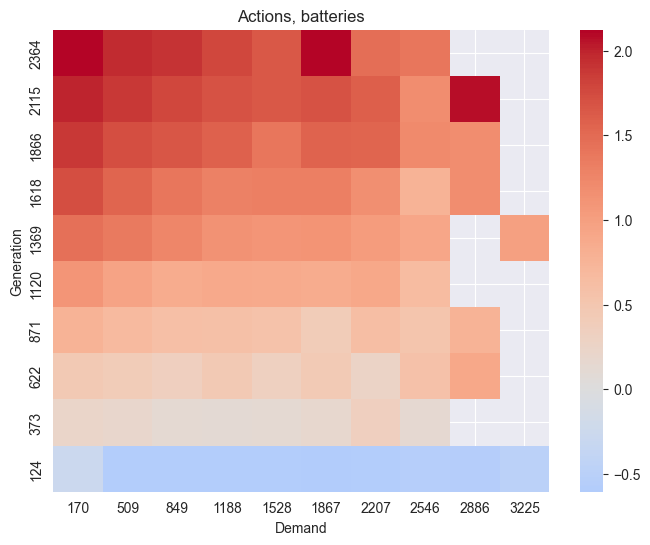

In [20]:
print_heatmap(info['demands'].flatten(), info['generations'].flatten(), info['actions_batteries'].flatten(), x_label='Demand', y_label='Generation', title='Actions, batteries')

In [21]:
info['actions_rec'].max()

Array(0.2750412, dtype=float32)

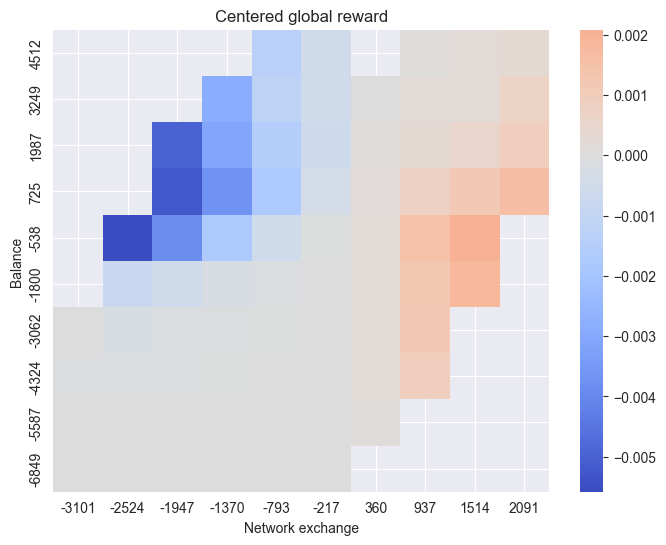

In [22]:
print_heatmap((info['generations']-info['demands']-info['energy_to_batteries']).T.flatten(), np.tile(info['balance_plus'] - info['balance_minus'], reps=info['r_glob'].shape[1]), (info['r_glob'] - info['r_glob'].mean(axis=1, keepdims=True)).T.flatten(), x_label='Network exchange', y_label='Balance', title='Centered global reward')

In [23]:
# print_heatmap((info['generations']-info['demands']-info['energy_to_batteries']).T.flatten(), np.tile(info['balance_plus'] - info['balance_minus'], reps=info['r_glob'].shape[1]), info['r_glob'].T.flatten(), x_label='Network exchange', y_label='Balance', title='Global reward')

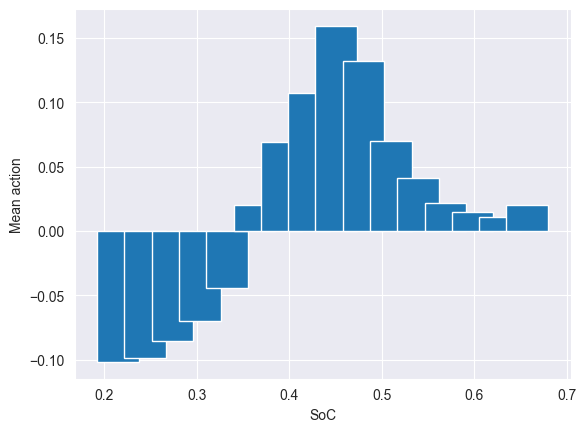

In [24]:
plot_hist_soc(logs['ppo']['soc'].flatten(), logs['ppo']['actions_batteries'].flatten())

## Recurrent PPO

In [25]:
@partial(jax.jit, static_argnums=(0, 1, 2, 3))
def test_recurrent_ppo(env:RECEnv, networks_batteries, network_rec, num_iter, rng):

    rng, _rng = jax.random.split(rng)

    obsv, env_state = env.reset(_rng, profile_index=0)

    networks_batteries.eval()
    network_rec.eval()

    act_state_batteries, cri_state_batteries = networks_batteries.get_initial_lstm_state()
    act_state_rec, cri_state_rec = network_rec.get_initial_lstm_state()

    @scan_tqdm(num_iter, print_rate=num_iter // 100)
    def _env_step(runner_state, unused):
        obsv_batteries, env_state, act_state_batteries, act_state_rec, rng, next_profile_index = runner_state

        pi, _, act_state_batteries, _ = networks_batteries(obsv_batteries, act_state_batteries, cri_state_batteries)
        #deterministic action
        actions_batteries = pi.mode()
        actions_batteries = actions_batteries.squeeze(axis=-1)
        # jax.debug.print('act bat {x}', x=actions_batteries)


        actions_first = {env.battery_agents[i]: actions_batteries[i] for i in range(env.num_battery_agents)}
        actions_first[env.rec_agent] = jnp.zeros(env.num_battery_agents)

        rng, _rng = jax.random.split(rng)
        obsv, env_state, reward_first, done_first, info_first = env.step(
            _rng, env_state, actions_first
        )

        rec_obsv = obsv[env.rec_agent]

        pi, _, act_state_rec, _ = network_rec(rec_obsv, act_state_rec, cri_state_rec)
        actions_rec = pi.mean()
        # jax.debug.print('{x}', x=pi.concentration)
        # jax.debug.print('act {x}', x=actions_rec)
        # actions_rec = jnp.zeros(env.num_battery_agents)

        actions_second = {agent: jnp.array(0.) for agent in env.battery_agents}
        actions_second[env.rec_agent] = actions_rec

        rng, _rng = jax.random.split(rng)
        obsv, env_state, reward_second, done_second, info_second = env.step(
            _rng, env_state, actions_second
        )

        done = jnp.logical_or(done_first['__all__'], done_second['__all__'])

        info = jax.tree.map(lambda  x, y: x + y, info_first, info_second)

        info['actions_batteries'] = actions_batteries
        info['actions_rec'] = actions_rec
        info['dones'] = jax.tree.map(lambda x, y : jnp.logical_or(x, y), done_first, done_second)

        rng, _rng = jax.random.split(rng)
        obsv, env_state,next_profile_index = jax.lax.cond(done,
                                                          lambda : env.reset(_rng, profile_index=next_profile_index) + (next_profile_index+1,),
                                                          lambda : (obsv, env_state, next_profile_index))

        obs_batteries = jnp.vstack([obsv[a] for a in env.battery_agents])

        runner_state = (obs_batteries, env_state, act_state_batteries, act_state_rec, rng, next_profile_index)
        return runner_state, info

    obsv_batteries = jnp.vstack([obsv[a] for a in env.battery_agents])

    runner_state = (obsv_batteries, env_state, act_state_batteries, act_state_rec, rng, 1)

    runner_state, info = jax.lax.scan(_env_step, runner_state, jnp.arange(num_iter))

    return info

In [26]:
# pack_options = "ernestogym/ernesto_jax/data/battery_new/pack.yaml"
# pack_options = "ernestogym/ernesto_jax/data/battery_new/pack_init_full_cheap.yaml"
pack_options = "ernestogym/ernesto_jax/data/battery_new/pack_init_half_full_cheap.yaml"

ecm = "ernestogym/ernesto_jax/data/battery_new/models/electrical/thevenin_pack.yaml"
# ecm = "ernestogym/ernesto_jax/data/battery_new/models/electrical/thevenin_fading_pack.yaml"
r2c = "ernestogym/ernesto_jax/data/battery_new/models/thermal/r2c_thermal_pack.yaml"
# bolun = "ernestogym/ernesto_jax/data/battery_new/models/aging/bolun_pack.yaml"
bolun = "ernestogym/ernesto_jax/data/battery_new/models/aging/bolun_pack.yaml"


# world = "ernestogym/envs_jax/multi_agent/world_deg_test.yaml"
# world = "ernestogym/envs_jax/multi_agent/world_deg_test_split_demands.yaml"
# world = "ernestogym/envs_jax/single_agent/world_fading.yaml"
# world = "ernestogym/envs_jax/multi_agent/world_deg_test_split_generations.yaml"
# world = "ernestogym/envs_jax/multi_agent/world_deg_test_split_generations_new_clip.yaml"




# world = "ernestogym/envs_jax/multi_agent/world_deg_test_split_generations_for_recurrent.yaml"

# world = 'ernestogym/envs_jax/multi_agent/world_deg_test_split_generations_for_recurrent_passive.yaml'
# world = 'ernestogym/envs_jax/multi_agent/world_deg_test_split_generations_for_recurrent_passive_scaled.yaml'

world = "ernestogym/envs_jax/multi_agent/world_deg_test_split_generations_for_recurrent_passive_no_gen.yaml"
# world = "ernestogym/envs_jax/multi_agent/world_deg_test_split_generations_for_recurrent_passive_scaled_no_gen.yaml"



# battery_type = 'fading'
# battery_type = 'degrading'
battery_type = 'degrading_dropflow'

params = parameter_generator(
    input_var='current',
    battery_options=pack_options,
    electrical_model=ecm,
    thermal_model=r2c,
    aging_model=bolun,
    world_options=world,
    # use_reward_normalization=True

)

# num_iter = 8760 * 28

params

yaaaas2


{'num_battery_agents': 4,
 'num_passive_houses': 1,
 'batteries': [{'sign_convention': 'passive',
   'params': {'nominal_voltage': 350.4,
    'nominal_capacity': 60.0,
    'nominal_dod': 0.8,
    'nominal_lifetime': 3000,
    'v_max': 398.4,
    'v_min': 288.0,
    'temp_ambient': 298.15,
    'nominal_cost': 1500.0},
   'bounds': {'voltage': {'low': 288.0, 'high': 398.4},
    'current': {'low': -180.0, 'high': 60.0},
    'power': {'low': -71712.0, 'high': 23904.0},
    'temperature': {'low': 273.15, 'high': 323.15},
    'temp_ambient': {'low': 273.15, 'high': 323.15},
    'soc': {'low': 0.2, 'high': 1.0},
    'soh': {'low': 0.6, 'high': 1.0}},
   'init': {'voltage': 310.8,
    'current': 0.0,
    'power': 0.0,
    'temperature': 293.15,
    'temp_ambient': 293.15,
    'soc': 0.5,
    'soh': 1.0}},
  {'sign_convention': 'passive',
   'params': {'nominal_voltage': 350.4,
    'nominal_capacity': 60.0,
    'nominal_dod': 0.8,
    'nominal_lifetime': 3000,
    'v_max': 398.4,
    'v_min': 2

In [27]:
directory = '/media/samuele/Disco/PycharmProjectsUbuntu/MARL-CER/trained_agents/20250324_041758_bat_net_type_recurrent_actor_critic_rec_net_type_recurrent_actor_critic_lr_bat_0.0001_lr_REC_cosine_tot_timesteps_5256000_lr_sched_cosine_multiagent/checkpoints/20250324_061621_10'

networks_batteries, network_rec, config, params_training, train_info_recurrent_ppo, val_info_recurrent_ppo = restore_state_multi_agent(directory)

In [28]:
env = my_env_creator(params, battery_type, config['ENV_TYPE'])

norm? False


In [29]:
params_training

In [30]:
config

{'ACTIVATION': 'tanh',
 'BATTERY_ACTION_SPACE_SIZE': 1,
 'BATTERY_NUM_SEQUENCES': 7,
 'BATTERY_OBSERVATION_SPACE_SIZE': 11,
 'BATTERY_OBS_IS_NORMALIZABLE': (True,
  False,
  True,
  True,
  True,
  True,
  True,
  False,
  False,
  False,
  False),
 'CLIP_EPS': 0.2,
 'DEBUG': False,
 'ENT_COEF': 0.0,
 'ENV_NAME': None,
 'ENV_TYPE': 'normal',
 'GAE_LAMBDA': 0.98,
 'GAMMA': 0.99,
 'LOGISTIC_FUNCTION_TO_ACTOR': False,
 'LR_BATTERIES': 0.0001,
 'LR_BATTERIES_MIN': 1e-06,
 'LR_REC': 0.0001,
 'LR_REC_MIN': 1e-06,
 'LR_SCHEDULE': 'cosine',
 'LSTM_ACTIVATION': 'tanh',
 'LSTM_NET_ARCH': (24, 12),
 'MAX_GRAD_NORM': 0.5,
 'MINIBATCH_SIZE': 512,
 'NETWORK_TYPE_BATTERIES': 'recurrent_actor_critic',
 'NETWORK_TYPE_REC': 'recurrent_actor_critic',
 'NET_ARCH': (64, 32, 16),
 'NORMALIZE_ADVANTAGES': True,
 'NORMALIZE_ENV': False,
 'NORMALIZE_NN_INPUTS': True,
 'NORMALIZE_REWARD_FOR_GAE_AND_TARGETS': False,
 'NORMALIZE_TARGETS': False,
 'NUM_BATTERY_AGENTS': 4,
 'NUM_ENVS': 4,
 'NUM_MINIBATCHES': 64,
 '

In [31]:
info = test_recurrent_ppo(env, networks_batteries, network_rec, num_iter, jax.random.PRNGKey(51))
logs['recurrent_ppo'] = info

Running for 43,800 iterations:   0%|          | 0/43800 [00:00<?, ?it/s]

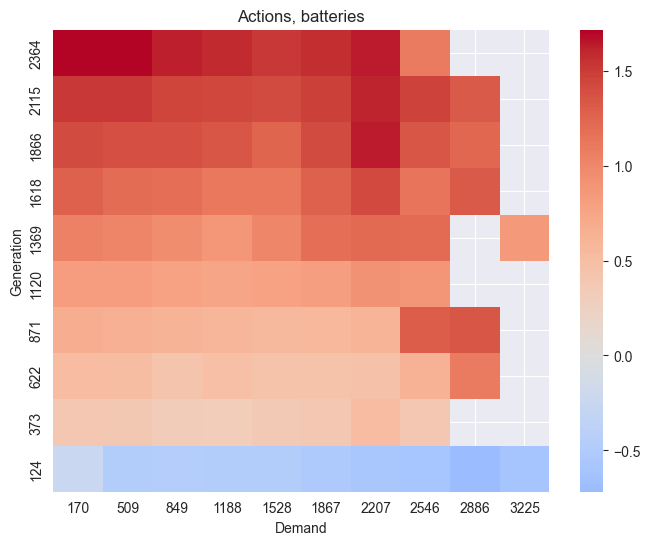

In [32]:
print_heatmap(info['demands'].flatten(), info['generations'].flatten(), info['actions_batteries'].flatten(), x_label='Demand', y_label='Generation', title='Actions, batteries')

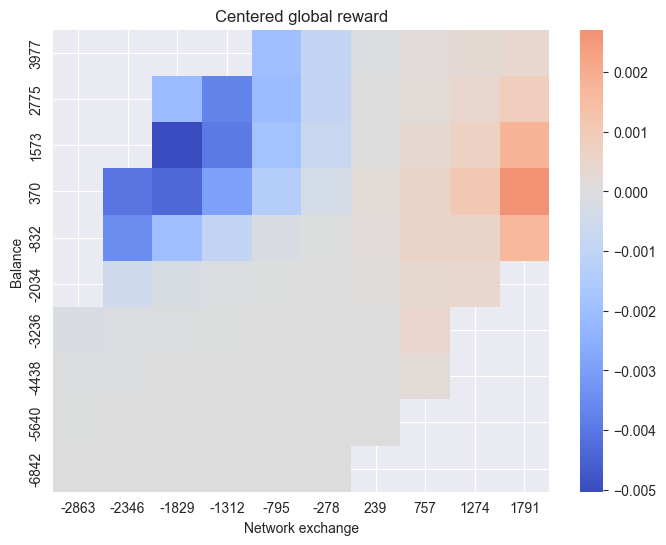

In [33]:
print_heatmap((info['generations']-info['demands']-info['energy_to_batteries']).T.flatten(), np.tile(info['balance_plus'] - info['balance_minus'], reps=info['r_glob'].shape[1]), (info['r_glob'] - info['r_glob'].mean(axis=1, keepdims=True)).T.flatten(), x_label='Network exchange', y_label='Balance', title='Centered global reward')

In [34]:
# print_heatmap((info['generations']-info['demands']-info['energy_to_batteries']).T.flatten(), np.tile(info['balance_plus'] - info['balance_minus'], reps=info['r_glob'].shape[1]), info['r_glob'].T.flatten(), x_label='Network exchange', y_label='Balance', title='Global reward')

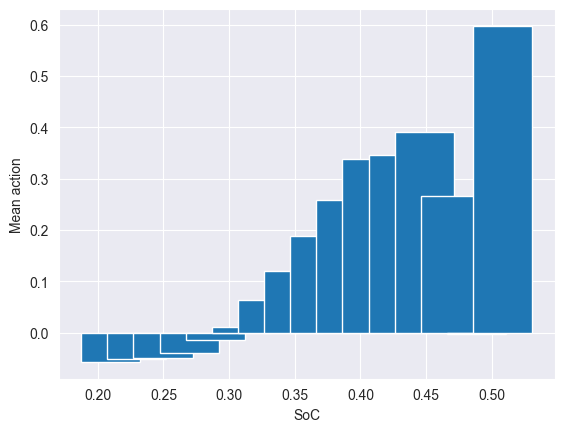

In [35]:
plot_hist_soc(logs['recurrent_ppo']['soc'].flatten(), logs['recurrent_ppo']['actions_batteries'].flatten())

## Random

In [36]:
@partial(jax.jit, static_argnums=(0, 1))
def test_random(env:RECEnv, num_iter, rng):

    rng, _rng = jax.random.split(rng)

    obsv, env_state = env.reset(_rng, profile_index=0)

    @scan_tqdm(num_iter, print_rate=num_iter // 100)
    def _env_step(runner_state, unused):
        env_state, rng, next_profile_index = runner_state

        rng, _rng = jax.random.split(rng)
        actions_batteries = jax.random.uniform(_rng, shape=(env.num_battery_agents,), minval=env.i_min_action, maxval=env.i_max_action)

        actions_first = {env.battery_agents[i]: actions_batteries[i] for i in range(env.num_battery_agents)}
        actions_first[env.rec_agent] = jnp.zeros(env.num_battery_agents)

        rng, _rng = jax.random.split(rng)
        obsv, env_state, reward_first, done_first, info_first = env.step(
            _rng, env_state, actions_first
        )

        actions_rec = jnp.ones(env.num_battery_agents)/env.num_battery_agents

        actions_second = {agent: jnp.array(0.) for agent in env.battery_agents}
        actions_second[env.rec_agent] = actions_rec

        rng, _rng = jax.random.split(rng)
        obsv, env_state, reward_second, done_second, info_second = env.step(
            _rng, env_state, actions_second
        )

        done = jnp.logical_or(done_first['__all__'], done_second['__all__'])

        info = jax.tree.map(lambda  x, y: x + y, info_first, info_second)

        info['actions_batteries'] = actions_batteries
        info['actions_rec'] = actions_rec

        rng, _rng = jax.random.split(rng)
        obsv, env_state,next_profile_index = jax.lax.cond(done,
                                                          lambda : env.reset(_rng, profile_index=next_profile_index) + (next_profile_index+1,),
                                                          lambda : (obsv, env_state, next_profile_index))

        runner_state = (env_state, rng, next_profile_index)
        return runner_state, info

    runner_state = (env_state, rng, 1)

    runner_state, info = jax.lax.scan(_env_step, runner_state, jnp.arange(num_iter))

    return info

In [37]:
# info = test_random(env, num_iter, jax.random.PRNGKey(51))
# logs['random'] = info

## Only market

In [38]:
@partial(jax.jit, static_argnums=(0, 1))
def test_only_market(env:RECEnv, num_iter, rng):

    rng, _rng = jax.random.split(rng)

    obsv, env_state = env.reset(_rng, profile_index=0)

    @scan_tqdm(num_iter, print_rate=num_iter // 100)
    def _env_step(runner_state, unused):
        env_state, rng, next_profile_index = runner_state

        rng, _rng = jax.random.split(rng)
        actions_batteries = jnp.zeros((env.num_battery_agents,))# + jax.random.normal(_rng)*(jnp.e**(-1))# + 0.01 * jnp.sin((unused%8760)*(2*jnp.pi) * 1./8760)

        # actions_batteries = jax.lax.select(unused < 8760, actions_batteries+0.01*365 * jnp.sin((unused%8760)*(2*jnp.pi) * 365./8760), actions_batteries)

        actions_first = {env.battery_agents[i]: actions_batteries[i] for i in range(env.num_battery_agents)}
        actions_first[env.rec_agent] = jnp.zeros(env.num_battery_agents)

        rng, _rng = jax.random.split(rng)
        obsv, env_state, reward_first, done_first, info_first = env.step(
            _rng, env_state, actions_first
        )

        actions_rec = jnp.ones(env.num_battery_agents)/env.num_battery_agents

        actions_second = {agent: jnp.array(0.) for agent in env.battery_agents}
        actions_second[env.rec_agent] = actions_rec

        rng, _rng = jax.random.split(rng)
        obsv, env_state, reward_second, done_second, info_second = env.step(
            _rng, env_state, actions_second
        )

        done = jnp.logical_or(done_first['__all__'], done_second['__all__'])

        info = jax.tree.map(lambda  x, y: x + y, info_first, info_second)

        info['actions_batteries'] = actions_batteries
        info['actions_rec'] = actions_rec

        rng, _rng = jax.random.split(rng)
        obsv, env_state,next_profile_index = jax.lax.cond(done,
                                                          lambda : env.reset(_rng, profile_index=next_profile_index) + (next_profile_index+1,),
                                                          lambda : (obsv, env_state, next_profile_index))

        runner_state = (env_state, rng, next_profile_index)
        return runner_state, info

    runner_state = (env_state, rng, 1)

    runner_state, info = jax.lax.scan(_env_step, runner_state, jnp.arange(num_iter))

    return info

In [39]:
info = test_only_market(env, num_iter, jax.random.PRNGKey(51))
logs['only_market'] = info

Running for 43,800 iterations:   0%|          | 0/43800 [00:00<?, ?it/s]

In [40]:
np.sum(info['pure_reward']['r_deg'][:, 0])

Array(-687.78656, dtype=float32)

## Battery first

In [41]:
@partial(jax.jit, static_argnums=(0, 1))
def test_battery_first(env:RECEnv, num_iter, rng):

    rng, _rng = jax.random.split(rng)

    obsv, env_state = env.reset(_rng, profile_index=0)

    @scan_tqdm(num_iter, print_rate=num_iter // 100)
    def _env_step(runner_state, unused):
        obsv_batteries, env_state, rng, next_profile_index = runner_state

        demand = obsv_batteries[:, env._obs_battery_agents_idx['demand']]
        generation = obsv_batteries[:, env._obs_battery_agents_idx['generation']]

        actions_batteries = (generation - demand) / env_state.battery_states.electrical_state.v


        actions_first = {env.battery_agents[i]: actions_batteries[i] for i in range(env.num_battery_agents)}
        actions_first[env.rec_agent] = jnp.zeros(env.num_battery_agents)

        rng, _rng = jax.random.split(rng)
        obsv, env_state, reward_first, done_first, info_first = env.step(
            _rng, env_state, actions_first
        )

        actions_rec = jnp.ones(env.num_battery_agents)/env.num_battery_agents

        actions_second = {agent: jnp.array(0.) for agent in env.battery_agents}
        actions_second[env.rec_agent] = actions_rec

        rng, _rng = jax.random.split(rng)
        obsv, env_state, reward_second, done_second, info_second = env.step(
            _rng, env_state, actions_second
        )

        done = jnp.logical_or(done_first['__all__'], done_second['__all__'])

        info = jax.tree.map(lambda  x, y: x + y, info_first, info_second)

        info['actions_batteries'] = actions_batteries
        info['actions_rec'] = actions_rec

        rng, _rng = jax.random.split(rng)
        obsv, env_state,next_profile_index = jax.lax.cond(done,
                                                          lambda : env.reset(_rng, profile_index=next_profile_index) + (next_profile_index+1,),
                                                          lambda : (obsv, env_state, next_profile_index))

        obs_batteries = jnp.vstack([obsv[a] for a in env.battery_agents])

        runner_state = (obs_batteries, env_state, rng, next_profile_index)
        return runner_state, info

    obsv_batteries = jnp.vstack([obsv[a] for a in env.battery_agents])

    runner_state = (obsv_batteries, env_state, rng, 1)

    runner_state, info = jax.lax.scan(_env_step, runner_state, jnp.arange(num_iter))

    return info

In [42]:
info = test_battery_first(env, num_iter, jax.random.PRNGKey(51))
logs['battery_first'] = info

Running for 43,800 iterations:   0%|          | 0/43800 [00:00<?, ?it/s]

In [43]:
print(info['weig_reward']['r_trad'].sum(axis=0))
print(info['weig_reward']['r_deg'].sum(axis=0))

[ -485.31378  -542.1875   -691.9679  -1981.3013 ]
[-871.4497 -892.3274 -857.5214 -543.817 ]


In [44]:
jax.tree.map(lambda x: x.shape, logs)

{'battery_first': {'actions_batteries': (43800, 4),
  'actions_rec': (43800, 4),
  'balance_minus': (43800,),
  'balance_plus': (43800,),
  'buy_prices': (43800, 4),
  'demands': (43800, 4),
  'energy_to_batteries': (43800, 4),
  'generations': (43800, 4),
  'norm_reward': {'r_clipping': (43800, 4),
   'r_deg': (43800, 4),
   'r_op': (43800, 4),
   'r_trad': (43800, 4)},
  'pure_reward': {'r_clipping': (43800, 4),
   'r_deg': (43800, 4),
   'r_op': (43800, 4),
   'r_trad': (43800, 4)},
  'r_glob': (43800, 4),
  'r_tot': (43800, 4),
  'rec_reward': (43800,),
  'self_consumption': (43800,),
  'sell_prices': (43800, 4),
  'soc': (43800, 4),
  'soh': (43800, 4),
  'tot_incentives': (43800,),
  'weig_reward': {'r_clipping': (43800, 4),
   'r_deg': (43800, 4),
   'r_op': (43800, 4),
   'r_trad': (43800, 4)}},
 'only_market': {'actions_batteries': (43800, 4),
  'actions_rec': (43800, 4),
  'balance_minus': (43800,),
  'balance_plus': (43800,),
  'buy_prices': (43800, 4),
  'demands': (43800, 

In [45]:
# jax.tree.map(lambda x: x.shape, logs['ppo'])

# Plotting

In [46]:
logs = jax.tree.map(lambda x : np.asarray(x), logs)

algs = ['ppo', 'recurrent_ppo']

In [47]:
# logs['ppo']['actions_rec'][28109]

In [48]:
np.sum(np.isnan(logs['ppo']['actions_rec']).any(axis=1))

0

In [49]:
# logs['ppo']['actions_rec']

In [50]:
# jax.tree.map(lambda x: jnp.isnan(x).any(), logs['recurrent_ppo'])

In [51]:
print('Tot self consumption')
for alg in algs:
    print(f'\t{alg}: {np.sum(logs[alg]['self_consumption'])}')

print('Tot reward')
for alg in algs:
    print(f'\t{alg}: {np.sum(logs[alg]['r_tot'])}')

print('Tot glob reward')
for alg in algs:
    print(f'\t{alg}: {np.sum(logs[alg]['r_glob'])}')

print('Tot trad reward')
for alg in algs:
    print(f'\t{alg}: {np.sum(logs[alg]['weig_reward']['r_trad'])}')

print('Tot deg reward')
for alg in algs:
    print(f'\t{alg}: {np.sum(logs[alg]['weig_reward']['r_deg'])}')

print('Tot clipping reward')
for alg in algs:
    print(f'\t{alg}: {np.sum(logs[alg]['weig_reward']['r_clipping'])}')

print('Tot rec reward')
for alg in algs:
    print(f'\t{alg}: {np.sum(logs[alg]['rec_reward'])}')

print('\n\n')

print('Mean rec actions')
for alg in algs:
    print(f'\t{alg}: {np.mean(logs[alg]['actions_rec'], axis=0)}')
print('Mean of variance rec actions')
for alg in algs:
    print(f'\t{alg}: {np.mean(np.var(logs[alg]['actions_rec'], axis=1))}')
print('Mean of difference max-min rec actions')
for alg in algs:
    print(f'\t{alg}: {np.mean(np.max(logs[alg]['actions_rec'], axis=1) - np.min(logs[alg]['actions_rec'], axis=1))}')

print('Pearson correlation coeff')
for alg in algs:
    v1 = logs[alg]['actions_rec']
    v2 = (logs[alg]['generations']-logs[alg]['demands']-logs[alg]['energy_to_batteries']) * (logs[alg]['balance_plus'] - logs[alg]['balance_minus'])[:, None]
    coeff = np.mean((v1 - v1.mean(axis=0, keepdims=True)) * (v2 - v2.mean(axis=0, keepdims=True)), axis=0)
    norm_coeff = coeff/np.sqrt(np.var(v1, axis=0)*np.var(v2, axis=0))
    print(f'\t{alg}: {coeff}\t\t{norm_coeff}')


Tot self consumption
	ppo: 14395906.0
	recurrent_ppo: 13833139.0
Tot reward
	ppo: -5072.16015625
	recurrent_ppo: -5041.69921875
Tot glob reward
	ppo: 1418.382080078125
	recurrent_ppo: 1361.544677734375
Tot trad reward
	ppo: -3730.761962890625
	recurrent_ppo: -3897.35546875
Tot deg reward
	ppo: -2759.516845703125
	recurrent_ppo: -2500.369873046875
Tot clipping reward
	ppo: -0.2640600800514221
	recurrent_ppo: -5.518657684326172
Tot rec reward
	ppo: 14395906.0
	recurrent_ppo: 13833139.0



Mean rec actions
	ppo: [0.25153145 0.25136402 0.2511186  0.2459871 ]
	recurrent_ppo: [0.25227794 0.2526716  0.25140187 0.24364606]
Mean of variance rec actions
	ppo: 4.153658665018156e-05
	recurrent_ppo: 9.480465814704075e-05
Mean of difference max-min rec actions
	ppo: 0.01332100760191679
	recurrent_ppo: 0.018183425068855286
Pearson correlation coeff
	ppo: [-1491.1615 -1114.064  -1367.8016  1039.898 ]		[-0.23563603 -0.20404014 -0.20097272  0.16609657]
	recurrent_ppo: [ 825.96356  310.71106 -603.85114 2

In [52]:
import statsmodels.api as sm

alg = 'ppo'

# a = logs[alg]['actions_rec'].T.flatten()
a = (logs[alg]['r_glob'] - logs[alg]['r_glob'].mean(axis=1, keepdims=True)).T.flatten()

b = (logs[alg]['generations']-logs[alg]['demands']-logs[alg]['energy_to_batteries']).T.flatten()
c = np.tile(logs[alg]['balance_plus'] - logs[alg]['balance_minus'], reps=logs[alg]['r_glob'].shape[1])

print(np.corrcoef(b, c)[0, 1])

X = np.column_stack((b, c, b * c))  # Independent variables
X = sm.add_constant(X)  # Add intercept
model = sm.OLS(a, X).fit()

print(model.summary())

0.6046376588198789
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.488
Model:                            OLS   Adj. R-squared:                  0.488
Method:                 Least Squares   F-statistic:                 5.568e+04
Date:                Thu, 27 Mar 2025   Prob (F-statistic):               0.00
Time:                        12:40:21   Log-Likelihood:             1.1450e+06
No. Observations:              175200   AIC:                        -2.290e+06
Df Residuals:                  175196   BIC:                        -2.290e+06
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0001   9.86e-07 

In [53]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

X = np.column_stack((b, c, b * c))
vif = [variance_inflation_factor(X, i) for i in range(X.shape[1])]
print(vif)

[1.5454179091705376, 1.6038598445106722, 1.0851860397079705]


In [54]:
v1 = logs['recurrent_ppo']['actions_rec'][:, 0]
v2 = (logs['recurrent_ppo']['generations'][:, 0]-logs['recurrent_ppo']['demands'][:, 0]-logs['recurrent_ppo']['energy_to_batteries'][:, 0]) * (logs['recurrent_ppo']['balance_plus'] - logs['recurrent_ppo']['balance_minus'])

print(np.corrcoef(v1, v2))

print(v1.shape)
print(v2.shape)


np.mean((v1-v1.mean()) * (v2-v2.mean())) / np.sqrt(np.var(v1)*np.var(v2))

[[1.         0.08531744]
 [0.08531744 1.        ]]
(43800,)
(43800,)


0.08531743

In [55]:
logs['ppo']['actions_rec'].shape

(43800, 4)

In [56]:
logs['ppo']['self_consumption']

array([193.00958, 675.0559 , 473.9151 , ...,   0.     , 314.5811 ,
       104.18327], dtype=float32)

In [57]:
ac = logs['ppo']['actions_batteries']

ac.min(), ac.max(), ac.mean(), np.var(ac)

(-1.8661427, 2.328592, -0.00090905343, 0.86022633)

In [58]:
logs['ppo']['actions_rec'].mean(axis=0)

array([0.25153145, 0.25136402, 0.2511186 , 0.2459871 ], dtype=float32)

In [59]:
# train_info_ppo['actions']['battery_agent_0'].shape#, train_info_ppo['actions']['battery_agent_0'].max()

In [60]:
# val_info_ppo['actions_batteries'].max(axis=(1, 2)), val_info_ppo['actions_batteries'].min(axis=(1, 2))

In [61]:
algs = ['random', 'only_market', 'battery_first', 'ppo', 'recurrent_ppo']        #, 'recurrent_ppo']
# colors = {alg: col for alg, col in zip(algs, plotly.colors.sample_colorscale('rainbow', len(algs)))}
colors = plotly.colors.sample_colorscale('rainbow', env.num_battery_agents)
line_styles = {'random': 'dot',
               'only_market': 'dash',
               'battery_first': 'dashdot',
               'ppo': 'solid',
               'recurrent_ppo': 'longdash'}

def plot_data_plotly(demands, generations, sell_prices, buy_prices, log, algs, full_algs, time_step, reward_type='weig_reward', cumulative=True):

    n_points = max(demands.shape[0], generations.shape[0], sell_prices.shape[0], buy_prices.shape[0])
    # print(n_points)
    # print(demands.shape)

    time = pd.date_range('2015-01-01', periods=n_points, freq=str(int(time_step))+'s')
    fig = FigureWidgetResampler(make_subplots(rows=13, cols=1, shared_xaxes=True, vertical_spacing = 0.02, subplot_titles=['Power demand and generation', 'Market prices', 'SoC', 'Trad plus deg plus glob reward', 'Trading reward', 'Degradation reward', 'Clipping reward', 'Global reward', 'Actions', 'REC actions', 'REC reward','REC balances', 'Network exchange']), default_n_shown_samples=5000)
    # fig = make_subplots(rows=11, cols=1, shared_xaxes=True, vertical_spacing = 0.05, subplot_titles=['Power demand and generation', 'Market prices', 'SoC', 'Total reward', 'Trading reward', 'Degradation reward', 'Clipping reward', 'Global reward', 'Actions', 'REC reward', 'REC balances'])

    # print(time.shape)
    # print(demands[: 0].shape)

    for i in range(demands.shape[1]):
        fig.add_trace(go.Scatter(x=time, y=demands[:, i], mode='lines', legend='legend1', name=f'demand agent{i}', line=dict(color=colors[i], dash='solid')), row=1, col=1)
        fig.add_trace(go.Scatter(x=time, y=generations[:, i], mode='lines', legend='legend1', name=f'generation agent{i}', line=dict(color=colors[i], dash='dot')), row=1, col=1)


    fig.add_trace(go.Scatter(x=time, y=sell_prices[:, 0]*1000000, mode='lines', legend='legend2', name='Selling prices'), row=2, col=1)
    fig.add_trace(go.Scatter(x=time, y=buy_prices[:, 0]*1000000, mode='lines', legend='legend2', name='Buying prices'), row=2, col=1)

    rewards = {}
    for alg in algs:
        rewards[alg] = {}

    if cumulative:
        for alg in algs:
            rewards[alg]['r_tot'] = np.cumsum(log[alg]['r_tot'], axis=0)
            rewards[alg]['r_trad'] = np.cumsum(log[alg][reward_type]['r_trad'], axis=0)
            rewards[alg]['r_deg'] = np.cumsum(log[alg][reward_type]['r_deg'], axis=0)
            rewards[alg]['r_clipping'] = np.cumsum(log[alg][reward_type]['r_clipping'], axis=0)
            rewards[alg]['r_glob'] = np.cumsum(log[alg]['r_glob'], axis=0)
            rewards[alg]['r_rec'] = np.cumsum(log[alg]['rec_reward'])
    else:
        for alg in algs:
            rewards[alg]['r_tot'] = log[alg]['r_tot']
            rewards[alg]['r_trad'] = log[alg][reward_type]['r_trad']
            rewards[alg]['r_deg'] = log[alg][reward_type]['r_deg']
            rewards[alg]['r_clipping'] = log[alg][reward_type]['r_clipping']
            rewards[alg]['r_glob'] = log[alg]['r_glob']
            rewards[alg]['r_rec'] = log[alg]['rec_reward']

    for alg in full_algs:
        for i in range(demands.shape[1]):
            fig.add_trace(go.Scatter(x=time, y=log[alg]['soc'][:, i], line=dict(color=colors[i], dash=line_styles[alg]), mode='lines', legend='legend3', name=f'{alg} agent {i}'), row=3, col=1)
            fig.add_trace(go.Scatter(x=time, y=rewards[alg]['r_trad'][:, i]+rewards[alg]['r_deg'][:, i]+rewards[alg]['r_glob'][:, i], line=dict(color=colors[i], dash=line_styles[alg]), mode='lines', legend='legend4', name=f'{alg} agent {i}'), row=4, col=1)
            fig.add_trace(go.Scatter(x=time, y=rewards[alg]['r_trad'][:, i], line=dict(color=colors[i], dash=line_styles[alg]), mode='lines', legend='legend5', name=f'{alg} agent {i}'), row=5, col=1)
            fig.add_trace(go.Scatter(x=time, y=rewards[alg]['r_deg'][:, i], line=dict(color=colors[i], dash=line_styles[alg]), mode='lines', legend='legend6', name=f'{alg} agent {i}'), row=6, col=1)
            fig.add_trace(go.Scatter(x=time, y=rewards[alg]['r_clipping'][:, i], line=dict(color=colors[i], dash=line_styles[alg]), mode='lines', legend='legend7', name=f'{alg} agent {i}'), row=7, col=1)
            fig.add_trace(go.Scatter(x=time, y=rewards[alg]['r_glob'][:, i], line=dict(color=colors[i], dash=line_styles[alg]), mode='lines', legend='legend8', name=f'{alg} agent {i}'), row=8, col=1)
            fig.add_trace(go.Scatter(x=time, y=log[alg]['actions_batteries'][:, i], line=dict(color=colors[i], dash=line_styles[alg]), mode='lines', legend='legend9', name=f'{alg} agent {i}'), row=9, col=1)
            fig.add_trace(go.Scatter(x=time, y=log[alg]['generations'][:, i]-log[alg]['demands'][:, i]-log[alg]['energy_to_batteries'][:, i], line=dict(color=colors[i], dash=line_styles[alg]), mode='lines', legend='legend13', name=f'{alg} agent {i}'), row=13, col=1)

    for alg in [alg for alg in algs if alg not in full_algs]:
        fig.add_trace(go.Scatter(x=time, y=log[alg]['soc'].mean(axis=1), line=dict(color='grey', dash=line_styles[alg]), mode='lines', legend='legend3', name=alg), row=3, col=1)
        fig.add_trace(go.Scatter(x=time, y=rewards[alg]['r_trad'].mean(axis=1) + rewards[alg]['r_deg'].mean(axis=1) + rewards[alg]['r_glob'].mean(axis=1), line=dict(color='grey', dash=line_styles[alg]), mode='lines', legend='legend4', name=alg), row=4, col=1)
        fig.add_trace(go.Scatter(x=time, y=rewards[alg]['r_trad'].mean(axis=1), line=dict(color='grey', dash=line_styles[alg]), mode='lines', legend='legend5', name=alg), row=5, col=1)
        fig.add_trace(go.Scatter(x=time, y=rewards[alg]['r_deg'].mean(axis=1), line=dict(color='grey', dash=line_styles[alg]), mode='lines', legend='legend6', name=alg), row=6, col=1)
        fig.add_trace(go.Scatter(x=time, y=rewards[alg]['r_clipping'].mean(axis=1), line=dict(color='grey', dash=line_styles[alg]), mode='lines', legend='legend7', name=alg), row=7, col=1)
        fig.add_trace(go.Scatter(x=time, y=rewards[alg]['r_glob'].mean(axis=1), line=dict(color='grey', dash=line_styles[alg]), mode='lines', legend='legend8', name=alg), row=8, col=1)
        fig.add_trace(go.Scatter(x=time, y=log[alg]['actions_batteries'].mean(axis=1), line=dict(color='grey', dash=line_styles[alg]), mode='lines', legend='legend9', name=alg), row=9, col=1)

    print(log[alg]['actions_rec'][0].shape, time.shape)

    for alg in algs:
        for i in range(demands.shape[1]):
            fig.add_trace(go.Scatter(x=time, y=log[alg]['actions_rec'][:, i], line=dict(color=colors[i], dash=line_styles[alg]), mode='lines', legend='legend10', name=alg), row=10, col=1)
        fig.add_trace(go.Scatter(x=time, y=rewards[alg]['r_rec'], line=dict(color='grey', dash=line_styles[alg]), mode='lines', legend='legend11', name=alg), row=11, col=1)
        fig.add_trace(go.Scatter(x=time, y=log[alg]['balance_plus'], line=dict(color='green', dash=line_styles[alg]), mode='lines', legend='legend12', name=alg), row=12, col=1)
        fig.add_trace(go.Scatter(x=time, y=log[alg]['balance_minus'], line=dict(color='red', dash=line_styles[alg]), mode='lines', legend='legend12', name=alg), row=12, col=1)



    fig.update_layout(
        title='',
        xaxis=dict(tickformat='%b %d %H:00', showticklabels=True),
        xaxis2=dict(tickformat='%b %d %H:00', showticklabels=True),
        xaxis3=dict(tickformat='%b %d %H:00', showticklabels=True),
        xaxis4=dict(tickformat='%b %d %H:00', showticklabels=True),
        xaxis5=dict(tickformat='%b %d %H:00', showticklabels=True),
        xaxis6=dict(tickformat='%b %d %H:00', showticklabels=True),
        xaxis7=dict(tickformat='%b %d %H:00', showticklabels=True),
        xaxis8=dict(tickformat='%b %d %H:00', showticklabels=True),
        xaxis9=dict(tickformat='%b %d %H:00', showticklabels=True),
        xaxis10=dict(tickformat='%b %d %H:00', showticklabels=True),
        xaxis11=dict(tickformat='%b %d %H:00', showticklabels=True),
        xaxis12=dict(tickformat='%b %d %H:00', showticklabels=True),
        xaxis13=dict(tickformat='%b %d %H:00', showticklabels=True),

        yaxis=dict(fixedrange=True, title='Wh', minor=dict(ticklen=6, tickcolor="black", showgrid=True)),
        yaxis2=dict(fixedrange=True, title='€/MWh', minor=dict(ticklen=6, tickcolor="black", showgrid=True)),
        yaxis3=dict(fixedrange=True, minor=dict(ticklen=6, tickcolor="black", showgrid=True)),
        yaxis4=dict(fixedrange=True, minor=dict(ticklen=6, tickcolor="black", showgrid=True)),
        yaxis5=dict(fixedrange=True, minor=dict(ticklen=6, tickcolor="black", showgrid=True)),
        yaxis6=dict(fixedrange=True, minor=dict(ticklen=6, tickcolor="black", showgrid=True)),
        yaxis7=dict(fixedrange=True, minor=dict(ticklen=6, tickcolor="black", showgrid=True)),
        yaxis8=dict(fixedrange=True, minor=dict(ticklen=6, tickcolor="black", showgrid=True)),
        yaxis9=dict(fixedrange=True, minor=dict(ticklen=6, tickcolor="black", showgrid=True)),
        yaxis10=dict(fixedrange=True, minor=dict(ticklen=6, tickcolor="black", showgrid=True)),
        yaxis11=dict(fixedrange=True, minor=dict(ticklen=6, tickcolor="black", showgrid=True)),
        yaxis12=dict(fixedrange=True, minor=dict(ticklen=6, tickcolor="black", showgrid=True)),
        yaxis13=dict(fixedrange=True, minor=dict(ticklen=6, tickcolor="black", showgrid=True)),

        height=3000,
        width=1200,
        legend_tracegroupgap=20
    )

    # fig.update_layout(
    # legends=[
    #     dict(x=1.05, y=0.95, tracegroup="group1"),  # Legend for first subplot
    #     dict(x=1.05, y=0.60, tracegroup="group2"),  # Legend for second subplot
    # ]
    # )

    fig.update_layout(
        legend1=dict(
            xref="container",
            yref="container",
            y=0.6),
        legend2=dict(
            xref="container",
            yref="container",
            y=0.1)
    )

    fig.write_html(directory + '/plots.html')
    print(directory + '/plots.html')


    display(fig)

In [62]:
logs['ppo']['actions_rec'].shape, logs['ppo']['r_tot'].shape

((43800, 4), (43800, 4))

In [63]:
env.init_state.battery_states.nominal_cost

Array([1500., 1500., 1500., 1500.], dtype=float32)

In [64]:
# plot_external_data_matplotlib(logs['ppo']['demand'], logs['ppo']['generation'], logs['ppo']['sell_price'], logs['ppo']['buy_price'], start=1000, length_max=200)
# algs_to_plot = ['only_market', 'battery_first', 'ppo', 'recurrent_ppo']
algs_to_plot = ['battery_first', 'only_market', 'ppo', 'recurrent_ppo']#, 'battery_first']
# algs_to_plot = ['ppo']      # ['only_market', 'ppo', 'recurrent_ppo']
full_algs = ['ppo', 'recurrent_ppo'] #['battery_first', 'only_market', 'recurrent_ppo']#, 'battery_first'] #['ppo']      #['only_market', 'ppo', 'recurrent_ppo']

dem_agent = algs_to_plot[0] # 'recurrent_ppo'

plot_data_plotly(logs[dem_agent]['demands'], logs[dem_agent]['generations'], logs[dem_agent]['sell_prices'], logs[dem_agent]['buy_prices'], logs, algs_to_plot, full_algs, env.env_step, reward_type='weig_reward', cumulative=True)

(4,) (43800,)
/media/samuele/Disco/PycharmProjectsUbuntu/MARL-CER/trained_agents/20250324_041758_bat_net_type_recurrent_actor_critic_rec_net_type_recurrent_actor_critic_lr_bat_0.0001_lr_REC_cosine_tot_timesteps_5256000_lr_sched_cosine_multiagent/checkpoints/20250324_061621_10/plots.html


FigureWidgetResampler({
    'data': [{'legend': 'legend',
              'line': {'color': 'rgb(150, 0, 90)', 'dash': 'solid'},
              'mode': 'lines',
              'name': ('<b style="color:sandybrown">[R' ... ' style="color:#fc9944">~9h</i>'),
              'type': 'scatter',
              'uid': '4271b573-0105-4d4d-886b-916e53962f56',
              'x': array([datetime.datetime(2015, 1, 1, 0, 0),
                          datetime.datetime(2015, 1, 1, 8, 0),
                          datetime.datetime(2015, 1, 1, 11, 0), ...,
                          datetime.datetime(2019, 12, 30, 2, 0),
                          datetime.datetime(2019, 12, 30, 16, 0),
                          datetime.datetime(2019, 12, 30, 23, 0)], dtype=object),
              'xaxis': 'x',
              'y': array([ 630.,   62., 1435., ...,   92., 2493., 1583.], dtype=float32),
              'yaxis': 'y'},
             {'legend': 'legend',
              'line': {'color': 'rgb(150, 0, 90)', 'dash': 'dot'

In [65]:
algs = ['random', 'only_market', 'battery_first', 'ppo', 'recurrent_ppo']        #, 'recurrent_ppo']
# colors = {alg: col for alg, col in zip(algs, plotly.colors.sample_colorscale('rainbow', len(algs)))}
colors = plotly.colors.sample_colorscale('rainbow', env.num_battery_agents)
line_styles = {'random': 'dot',
               'only_market': 'dash',
               'battery_first': 'dashdot',
               'ppo': 'solid',
               'recurrent_ppo': 'longdash'}

def plot_data_plotly(demands, generations, sell_prices, buy_prices, log, algs, full_algs, time_step, reward_type='weig_reward', cumulative=True):

    n_points = max(demands.shape[0], generations.shape[0], sell_prices.shape[0], buy_prices.shape[0])
    # print(n_points)
    # print(demands.shape)

    time = pd.date_range('2015-01-01', periods=n_points, freq=str(int(time_step))+'s')
    fig = FigureWidgetResampler(make_subplots(rows=13, cols=1, shared_xaxes=True, vertical_spacing = 0.02, subplot_titles=['Power demand and generation', 'Market prices', 'SoC', 'Trad plus deg plus glob reward', 'Trading reward', 'Degradation reward', 'Clipping reward', 'Global reward', 'Actions', 'REC actions', 'REC reward','REC balances', 'Network exchange']), default_n_shown_samples=5000)
    # fig = make_subplots(rows=11, cols=1, shared_xaxes=True, vertical_spacing = 0.05, subplot_titles=['Power demand and generation', 'Market prices', 'SoC', 'Total reward', 'Trading reward', 'Degradation reward', 'Clipping reward', 'Global reward', 'Actions', 'REC reward', 'REC balances'])

    # print(time.shape)
    # print(demands[: 0].shape)

    for i in range(demands.shape[1]):
        fig.add_trace(go.Scatter(x=time, y=demands[:, i], mode='lines', legend='legend1', name=f'demand agent{i}', line=dict(color=colors[i], dash='solid')), row=1, col=1)
        fig.add_trace(go.Scatter(x=time, y=generations[:, i], mode='lines', legend='legend1', name=f'generation agent{i}', line=dict(color=colors[i], dash='dot')), row=1, col=1)


    fig.add_trace(go.Scatter(x=time, y=sell_prices[:, 0]*1000000, mode='lines', legend='legend2', name='Selling prices'), row=2, col=1)
    fig.add_trace(go.Scatter(x=time, y=buy_prices[:, 0]*1000000, mode='lines', legend='legend2', name='Buying prices'), row=2, col=1)

    rewards = {}
    for alg in algs:
        rewards[alg] = {}

    if cumulative:
        for alg in algs:
            rewards[alg]['r_tot'] = np.cumsum(log[alg]['r_tot'], axis=0)
            rewards[alg]['r_trad'] = np.cumsum(log[alg][reward_type]['r_trad'], axis=0)
            rewards[alg]['r_deg'] = np.cumsum(log[alg][reward_type]['r_deg'], axis=0)
            rewards[alg]['r_clipping'] = np.cumsum(log[alg][reward_type]['r_clipping'], axis=0)
            rewards[alg]['r_glob'] = np.cumsum(log[alg]['r_glob'], axis=0)
            rewards[alg]['r_rec'] = np.cumsum(log[alg]['rec_reward'])
    else:
        for alg in algs:
            rewards[alg]['r_tot'] = log[alg]['r_tot']
            rewards[alg]['r_trad'] = log[alg][reward_type]['r_trad']
            rewards[alg]['r_deg'] = log[alg][reward_type]['r_deg']
            rewards[alg]['r_clipping'] = log[alg][reward_type]['r_clipping']
            rewards[alg]['r_glob'] = log[alg]['r_glob']
            rewards[alg]['r_rec'] = log[alg]['rec_reward']

    for alg in full_algs:
        for i in range(demands.shape[1]):
            fig.add_trace(go.Scatter(x=time, y=log[alg]['soc'][:, i], line=dict(color=colors[i], dash=line_styles[alg]), mode='lines', legend='legend3', name=f'{alg} agent {i}'), row=3, col=1)
            fig.add_trace(go.Scatter(x=time, y=rewards[alg]['r_trad'][:, i]+rewards[alg]['r_deg'][:, i]+rewards[alg]['r_glob'][:, i], line=dict(color=colors[i], dash=line_styles[alg]), mode='lines', legend='legend4', name=f'{alg} agent {i}'), row=4, col=1)
            fig.add_trace(go.Scatter(x=time, y=rewards[alg]['r_trad'][:, i], line=dict(color=colors[i], dash=line_styles[alg]), mode='lines', legend='legend5', name=f'{alg} agent {i}'), row=5, col=1)
            fig.add_trace(go.Scatter(x=time, y=rewards[alg]['r_deg'][:, i], line=dict(color=colors[i], dash=line_styles[alg]), mode='lines', legend='legend6', name=f'{alg} agent {i}'), row=6, col=1)
            fig.add_trace(go.Scatter(x=time, y=rewards[alg]['r_clipping'][:, i], line=dict(color=colors[i], dash=line_styles[alg]), mode='lines', legend='legend7', name=f'{alg} agent {i}'), row=7, col=1)
            fig.add_trace(go.Scatter(x=time, y=rewards[alg]['r_glob'][:, i], line=dict(color=colors[i], dash=line_styles[alg]), mode='lines', legend='legend8', name=f'{alg} agent {i}'), row=8, col=1)
            fig.add_trace(go.Scatter(x=time, y=log[alg]['actions_batteries'][:, i], line=dict(color=colors[i], dash=line_styles[alg]), mode='lines', legend='legend9', name=f'{alg} agent {i}'), row=9, col=1)
            fig.add_trace(go.Scatter(x=time, y=log[alg]['generations'][:, i]-log[alg]['demands'][:, i]-log[alg]['energy_to_batteries'][:, i], line=dict(color=colors[i], dash=line_styles[alg]), mode='lines', legend='legend13', name=f'{alg} agent {i}'), row=13, col=1)

    for alg in [alg for alg in algs if alg not in full_algs]:
        fig.add_trace(go.Scatter(x=time, y=log[alg]['soc'].mean(axis=1), line=dict(color='grey', dash=line_styles[alg]), mode='lines', legend='legend3', name=alg), row=3, col=1)
        fig.add_trace(go.Scatter(x=time, y=rewards[alg]['r_trad'].mean(axis=1) + rewards[alg]['r_deg'].mean(axis=1) + rewards[alg]['r_glob'].mean(axis=1), line=dict(color='grey', dash=line_styles[alg]), mode='lines', legend='legend4', name=alg), row=4, col=1)
        fig.add_trace(go.Scatter(x=time, y=rewards[alg]['r_trad'].mean(axis=1), line=dict(color='grey', dash=line_styles[alg]), mode='lines', legend='legend5', name=alg), row=5, col=1)
        fig.add_trace(go.Scatter(x=time, y=rewards[alg]['r_deg'].mean(axis=1), line=dict(color='grey', dash=line_styles[alg]), mode='lines', legend='legend6', name=alg), row=6, col=1)
        fig.add_trace(go.Scatter(x=time, y=rewards[alg]['r_clipping'].mean(axis=1), line=dict(color='grey', dash=line_styles[alg]), mode='lines', legend='legend7', name=alg), row=7, col=1)
        fig.add_trace(go.Scatter(x=time, y=rewards[alg]['r_glob'].mean(axis=1), line=dict(color='grey', dash=line_styles[alg]), mode='lines', legend='legend8', name=alg), row=8, col=1)
        fig.add_trace(go.Scatter(x=time, y=log[alg]['actions_batteries'].mean(axis=1), line=dict(color='grey', dash=line_styles[alg]), mode='lines', legend='legend9', name=alg), row=9, col=1)

    print(log[alg]['actions_rec'][0].shape, time.shape)

    for alg in algs:
        for i in range(demands.shape[1]):
            fig.add_trace(go.Scatter(x=time, y=log[alg]['actions_rec'][:, i], line=dict(color=colors[i], dash=line_styles[alg]), mode='lines', legend='legend10', name=alg), row=10, col=1)
        fig.add_trace(go.Scatter(x=time, y=rewards[alg]['r_rec'], line=dict(color='grey', dash=line_styles[alg]), mode='lines', legend='legend11', name=alg), row=11, col=1)
        fig.add_trace(go.Scatter(x=time, y=log[alg]['balance_plus']-log[alg]['balance_minus'], line=dict(color='green', dash=line_styles[alg]), mode='lines', legend='legend12', name=alg), row=12, col=1)
        # fig.add_trace(go.Scatter(x=time, y=log[alg]['balance_minus'], line=dict(color='red', dash=line_styles[alg]), mode='lines', legend='legend12', name=alg), row=12, col=1)



    fig.update_layout(
        title='',
        xaxis=dict(tickformat='%b %d %H:00', showticklabels=True),
        xaxis2=dict(tickformat='%b %d %H:00', showticklabels=True),
        xaxis3=dict(tickformat='%b %d %H:00', showticklabels=True),
        xaxis4=dict(tickformat='%b %d %H:00', showticklabels=True),
        xaxis5=dict(tickformat='%b %d %H:00', showticklabels=True),
        xaxis6=dict(tickformat='%b %d %H:00', showticklabels=True),
        xaxis7=dict(tickformat='%b %d %H:00', showticklabels=True),
        xaxis8=dict(tickformat='%b %d %H:00', showticklabels=True),
        xaxis9=dict(tickformat='%b %d %H:00', showticklabels=True),
        xaxis10=dict(tickformat='%b %d %H:00', showticklabels=True),
        xaxis11=dict(tickformat='%b %d %H:00', showticklabels=True),
        xaxis12=dict(tickformat='%b %d %H:00', showticklabels=True),
        xaxis13=dict(tickformat='%b %d %H:00', showticklabels=True),

        yaxis=dict(fixedrange=True, title='Wh', minor=dict(ticklen=6, tickcolor="black", showgrid=True)),
        yaxis2=dict(fixedrange=True, title='€/MWh', minor=dict(ticklen=6, tickcolor="black", showgrid=True)),
        yaxis3=dict(fixedrange=True, minor=dict(ticklen=6, tickcolor="black", showgrid=True)),
        yaxis4=dict(fixedrange=True, minor=dict(ticklen=6, tickcolor="black", showgrid=True)),
        yaxis5=dict(fixedrange=True, minor=dict(ticklen=6, tickcolor="black", showgrid=True)),
        yaxis6=dict(fixedrange=True, minor=dict(ticklen=6, tickcolor="black", showgrid=True)),
        yaxis7=dict(fixedrange=True, minor=dict(ticklen=6, tickcolor="black", showgrid=True)),
        yaxis8=dict(fixedrange=True, minor=dict(ticklen=6, tickcolor="black", showgrid=True)),
        yaxis9=dict(fixedrange=True, minor=dict(ticklen=6, tickcolor="black", showgrid=True)),
        yaxis10=dict(fixedrange=True, minor=dict(ticklen=6, tickcolor="black", showgrid=True)),
        yaxis11=dict(fixedrange=True, minor=dict(ticklen=6, tickcolor="black", showgrid=True)),
        yaxis12=dict(fixedrange=True, minor=dict(ticklen=6, tickcolor="black", showgrid=True)),
        yaxis13=dict(fixedrange=True, minor=dict(ticklen=6, tickcolor="black", showgrid=True)),

        height=3000,
        width=1200,
        legend_tracegroupgap=20
    )

    # fig.update_layout(
    # legends=[
    #     dict(x=1.05, y=0.95, tracegroup="group1"),  # Legend for first subplot
    #     dict(x=1.05, y=0.60, tracegroup="group2"),  # Legend for second subplot
    # ]
    # )

    fig.update_layout(
        legend1=dict(
            xref="container",
            yref="container",
            y=0.6),
        legend2=dict(
            xref="container",
            yref="container",
            y=0.1)
    )

    fig.write_html(directory + '/plots.html')
    print(directory + '/plots.html')


    display(fig)

In [66]:
# plot_external_data_matplotlib(logs['ppo']['demand'], logs['ppo']['generation'], logs['ppo']['sell_price'], logs['ppo']['buy_price'], start=1000, length_max=200)
# algs_to_plot = ['only_market', 'battery_first', 'ppo', 'recurrent_ppo']
algs_to_plot = ['battery_first', 'only_market', 'ppo', 'recurrent_ppo']#, 'battery_first']
# algs_to_plot = ['ppo']      # ['only_market', 'ppo', 'recurrent_ppo']
full_algs = ['ppo', 'recurrent_ppo'] #['battery_first', 'only_market', 'recurrent_ppo']#, 'battery_first'] #['ppo']      #['only_market', 'ppo', 'recurrent_ppo']

dem_agent = algs_to_plot[0] # 'recurrent_ppo'

plot_data_plotly(logs[dem_agent]['demands'], logs[dem_agent]['generations'], logs[dem_agent]['sell_prices'], logs[dem_agent]['buy_prices'], logs, algs_to_plot, full_algs, env.env_step, reward_type='weig_reward', cumulative=False)

(4,) (43800,)
/media/samuele/Disco/PycharmProjectsUbuntu/MARL-CER/trained_agents/20250324_041758_bat_net_type_recurrent_actor_critic_rec_net_type_recurrent_actor_critic_lr_bat_0.0001_lr_REC_cosine_tot_timesteps_5256000_lr_sched_cosine_multiagent/checkpoints/20250324_061621_10/plots.html


FigureWidgetResampler({
    'data': [{'legend': 'legend',
              'line': {'color': 'rgb(150, 0, 90)', 'dash': 'solid'},
              'mode': 'lines',
              'name': ('<b style="color:sandybrown">[R' ... ' style="color:#fc9944">~9h</i>'),
              'type': 'scatter',
              'uid': 'a924ba23-075c-4199-a34d-95ad270b98bf',
              'x': array([datetime.datetime(2015, 1, 1, 0, 0),
                          datetime.datetime(2015, 1, 1, 8, 0),
                          datetime.datetime(2015, 1, 1, 11, 0), ...,
                          datetime.datetime(2019, 12, 30, 2, 0),
                          datetime.datetime(2019, 12, 30, 16, 0),
                          datetime.datetime(2019, 12, 30, 23, 0)], dtype=object),
              'xaxis': 'x',
              'y': array([ 630.,   62., 1435., ...,   92., 2493., 1583.], dtype=float32),
              'yaxis': 'y'},
             {'legend': 'legend',
              'line': {'color': 'rgb(150, 0, 90)', 'dash': 'dot'

In [67]:

def plot_data_matplotlib(demands, generations, sell_prices, buy_prices, log, algs, full_algs, time_step, reward_type='weig_reward', cumulative=True):
    n_points = max(demands.shape[0], generations.shape[0], sell_prices.shape[0], buy_prices.shape[0])
    time = pd.date_range('2015-01-01', periods=n_points, freq=str(int(time_step))+'s')

    fig, axes = plt.subplots(nrows=11, ncols=1, figsize=(12, 30), sharex=True)
    titles = ["Power demand and generation", "Market prices", "SoC", "Total reward", "Trading reward",
              "Degradation reward", "Clipping reward", "Global reward", "Actions", "REC reward", "REC balances"]

    for ax, title in zip(axes, titles):
        ax.set_title(title)

    # Plot power demand and generation
    for i in range(demands.shape[1]):
        axes[0].plot(time, demands[:, i], label=f'demand agent {i}')
    axes[0].plot(time, generations[:, 0], color='grey', label='generation')
    axes[0].legend()

    # Plot market prices
    axes[1].plot(time, sell_prices[:, 0] * 1e6, label='Selling prices')
    axes[1].plot(time, buy_prices[:, 0] * 1e6, label='Buying prices')
    axes[1].legend()

    rewards = {alg: {} for alg in algs}

    if cumulative:
        for alg in algs:
            rewards[alg]['r_tot'] = np.cumsum(log[alg]['r_tot'], axis=0)
            rewards[alg]['r_trad'] = np.cumsum(log[alg][reward_type]['r_trad'], axis=0)
            rewards[alg]['r_deg'] = np.cumsum(log[alg][reward_type]['r_deg'], axis=0)
            rewards[alg]['r_clipping'] = np.cumsum(log[alg][reward_type]['r_clipping'], axis=0)
            rewards[alg]['r_glob'] = np.cumsum(log[alg]['r_glob'], axis=0)
            rewards[alg]['r_rec'] = np.cumsum(log[alg]['rec_reward'])
    else:
        for alg in algs:
            rewards[alg]['r_tot'] = log[alg]['r_tot']
            rewards[alg]['r_trad'] = log[alg][reward_type]['r_trad']
            rewards[alg]['r_deg'] = log[alg][reward_type]['r_deg']
            rewards[alg]['r_clipping'] = log[alg][reward_type]['r_clipping']
            rewards[alg]['r_glob'] = log[alg]['r_glob']
            rewards[alg]['r_rec'] = log[alg]['rec_reward']

    for alg in full_algs:
        for i in range(demands.shape[1]):
            axes[2].plot(time, log[alg]['soc'][:, i], label=f'{alg} agent {i}')
            axes[3].plot(time, rewards[alg]['r_tot'][:, i], label=f'{alg} agent {i}')
            axes[4].plot(time, rewards[alg]['r_trad'][:, i], label=f'{alg} agent {i}')
            axes[5].plot(time, rewards[alg]['r_deg'][:, i], label=f'{alg} agent {i}')
            axes[6].plot(time, rewards[alg]['r_clipping'][:, i], label=f'{alg} agent {i}')
            axes[7].plot(time, rewards[alg]['r_glob'][:, i], label=f'{alg} agent {i}')
            axes[8].plot(time, log[alg]['actions_batteries'][:, i], label=f'{alg} agent {i}')

    for alg in [alg for alg in algs if alg not in full_algs]:
        axes[2].plot(time, log[alg]['soc'].mean(axis=1), label=alg)
        axes[3].plot(time, rewards[alg]['r_tot'].mean(axis=1), label=alg)
        axes[4].plot(time, rewards[alg]['r_trad'].mean(axis=1), label=alg)
        axes[5].plot(time, rewards[alg]['r_deg'].mean(axis=1), label=alg)
        axes[6].plot(time, rewards[alg]['r_clipping'].mean(axis=1), label=alg)
        axes[7].plot(time, rewards[alg]['r_glob'].mean(axis=1), label=alg)
        axes[8].plot(time, log[alg]['actions_batteries'].mean(axis=1), label=alg)

    for alg in algs:
        axes[9].plot(time, rewards[alg]['r_rec'], label=alg)
        axes[10].plot(time, log[alg]['balance_plus'], color='green', label=f'{alg} balance_plus')
        axes[10].plot(time, log[alg]['balance_minus'], color='red', label=f'{alg} balance_minus')

    for ax in axes:
        ax.legend()

    plt.xlabel('Time')
    plt.tight_layout()
    plt.show()

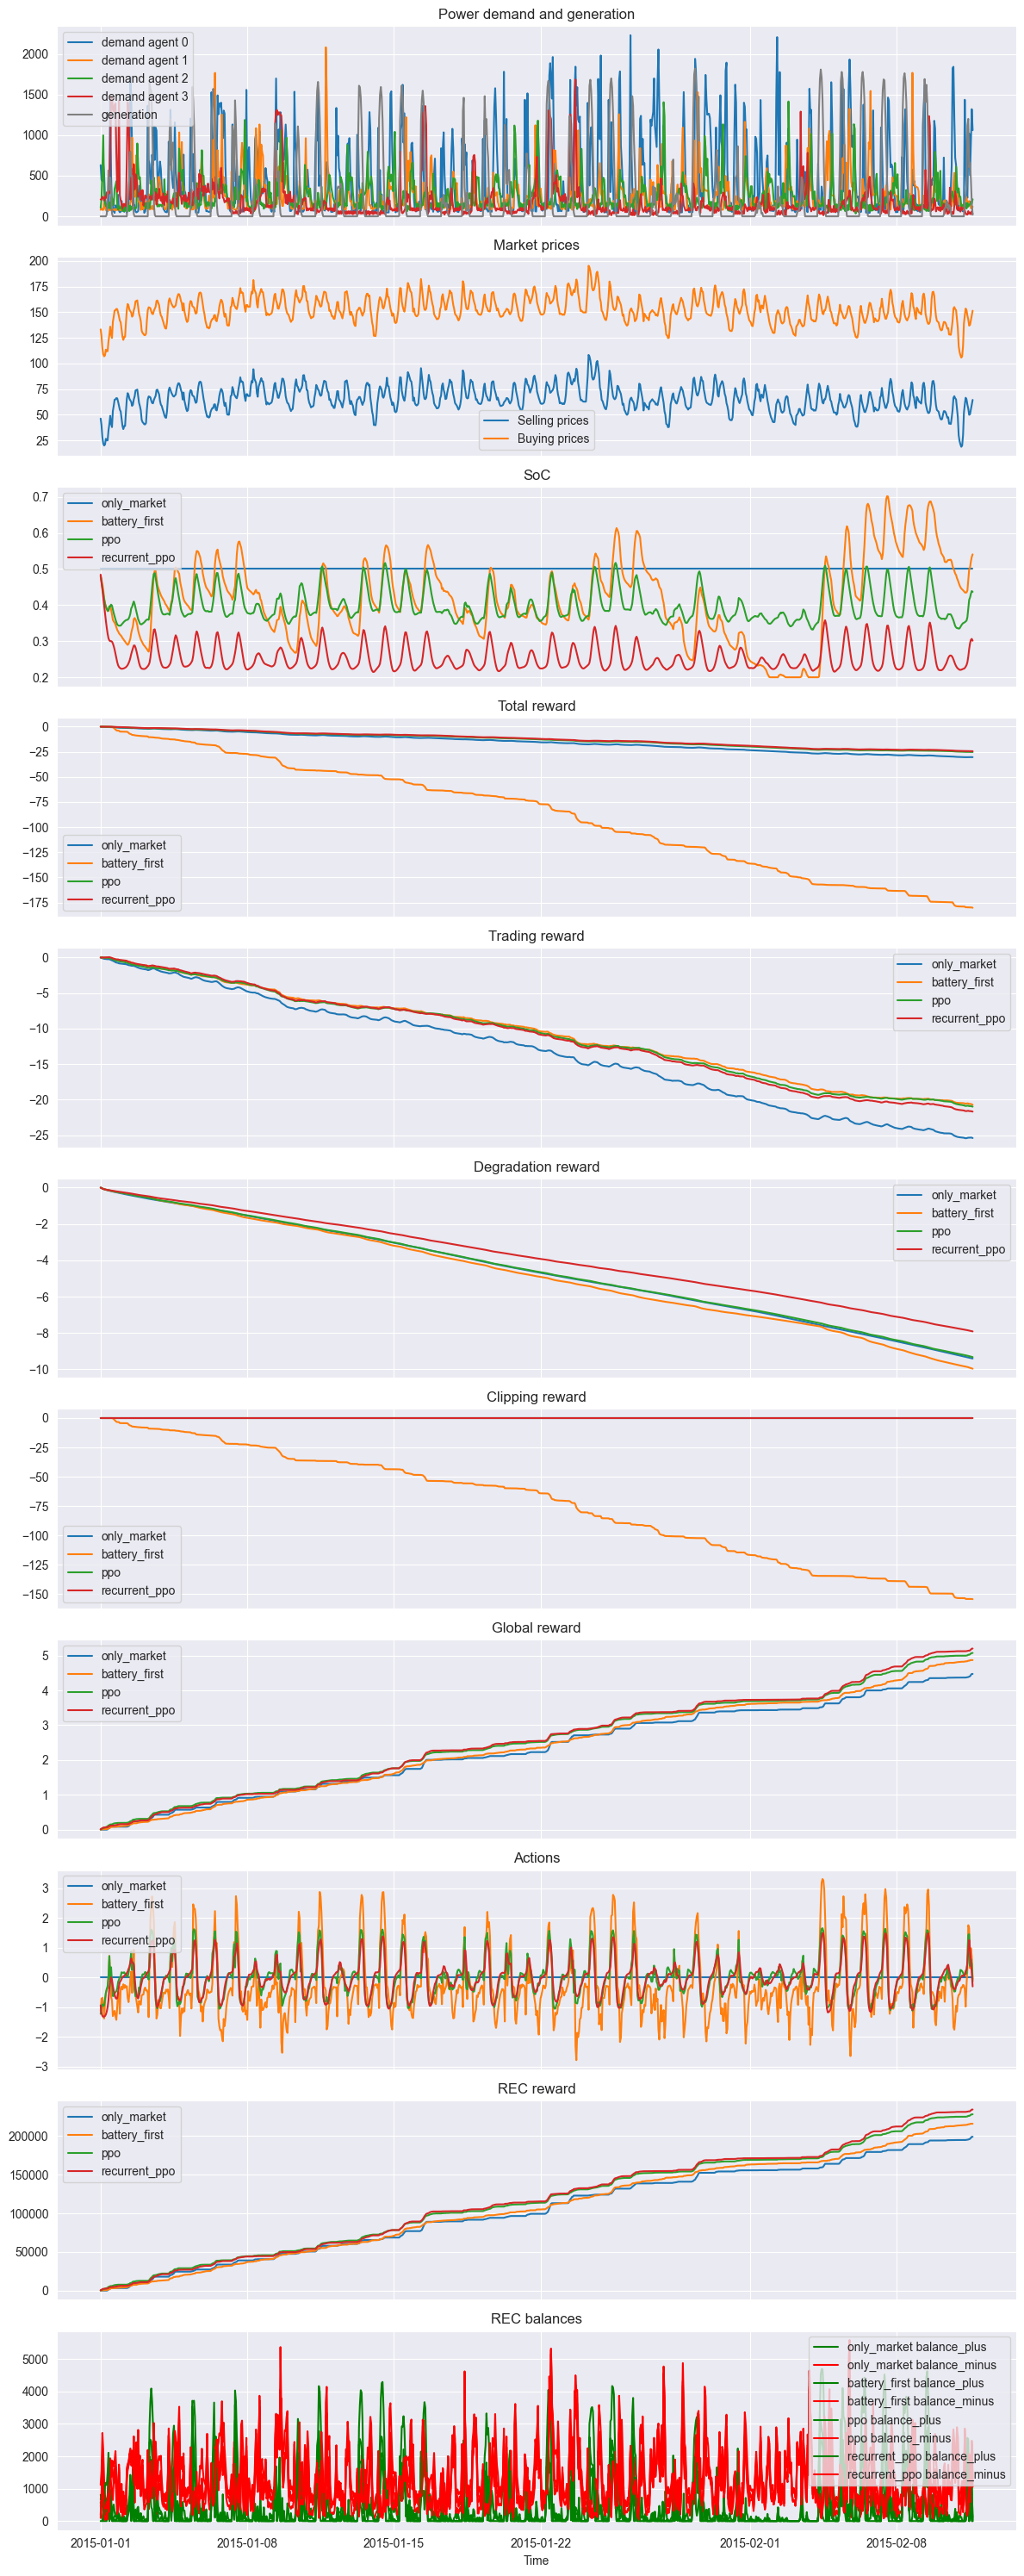

In [68]:
time_limit = 1000

algs_to_plot = ['only_market', 'battery_first', 'ppo', 'recurrent_ppo']
# algs_to_plot = ['ppo']      # ['only_market', 'ppo', 'recurrent_ppo']
full_algs = [] #['ppo']      #['only_market', 'ppo', 'recurrent_ppo']

log_slice = jax.tree.map(lambda x: x[:time_limit], logs)
plot_data_matplotlib(log_slice['ppo']['demands'], log_slice['ppo']['generations'], log_slice['ppo']['sell_prices'], log_slice['ppo']['buy_prices'], log_slice, algs_to_plot, full_algs, env.env_step, reward_type='weig_reward')

In [69]:
# plot_ext_data_and_reward_plotly(logs['ppo']['demand'], logs['ppo']['generation'], logs['ppo']['sell_price'], logs['ppo']['buy_price'], logs, algs_to_plot, env.params.env_step)

In [70]:
# plot_details_reward_plotly(logs, algs_to_plot, env.params.env_step)

In [71]:
summary = {}

for alg in algs:
    summary[alg] = {'mean_soc': np.mean(logs[alg]['soc']),
                    'r_tot': np.sum(logs[alg]['r_tot']),
                    # 'norm_reward': {'r_trad': np.sum(logs[alg]['norm_reward']['r_trad']),
                    #                 # 'r_op': np.sum(logs[alg]['norm_reward']['r_op']),
                    #                 'r_deg': np.sum(logs[alg]['norm_reward']['r_deg']),
                    #                 'r_clipping': np.sum(logs[alg]['norm_reward']['r_clipping'])},
                    'weig_reward': {'r_trad': np.sum(logs[alg]['weig_reward']['r_trad']),
                                    # 'r_op': np.sum(logs[alg]['weig_reward']['r_op']),
                                    'r_deg': np.sum(logs[alg]['weig_reward']['r_deg']),
                                    'r_clipping': np.sum(logs[alg]['weig_reward']['r_clipping'])},
                    'pure_reward': {'r_trad': np.sum(logs[alg]['pure_reward']['r_trad']),
                                    # 'r_op': np.sum(logs[alg]['pure_reward']['r_op']),
                                    'r_deg': np.sum(logs[alg]['pure_reward']['r_deg']),
                                    'r_clipping': np.sum(logs[alg]['pure_reward']['r_clipping'])},
                    'mean_action': np.mean(logs[alg]['actions']),
                    'max_action': np.max(logs[alg]['actions']),
                    'min_action': np.min(logs[alg]['actions']),
                    'variance_action': np.var(logs[alg]['actions']),
                    'final_soh': logs[alg]['soh'][-1],}

flatten_summary = {}

for alg in algs:
    flatten_summary[alg] = {}
    for key in summary[alg].keys():
        if isinstance(summary[alg][key], dict):
            flatten_summary[alg].update([(key+'.'+subkey, summary[alg][key][subkey]) for subkey in summary[alg][key].keys()])
        else:
            flatten_summary[alg][key] = summary[alg][key]


KeyError: 'random'

In [ ]:
df = pd.DataFrame.from_dict(flatten_summary, orient='index')
pd.set_option('display.max_columns', None)
df

In [ ]:
plt.plot(logs['only_market']['soh'][:int(len(logs['ppo']['soh'])/14)])